In [3]:
import torch
from model_explorer.workloads.unet import model

m = model

In [5]:

from torchinfo import summary
summary(m, (1, 3, 608, 800), depth=100)


Layer (type:depth-idx)                             Output Shape              Param #
UNet                                               [1, 13, 608, 800]         --
├─Encoder: 1-1                                     [1, 64, 304, 400]         --
│    └─FeatureListNet: 2-1                         [1, 64, 304, 400]         --
│    │    └─Conv2d: 3-1                            [1, 64, 304, 400]         9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 304, 400]         128
│    │    └─ReLU: 3-3                              [1, 64, 304, 400]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 152, 200]         --
│    │    └─Sequential: 3-5                        [1, 64, 152, 200]         --
│    │    │    └─BasicBlock: 4-1                   [1, 64, 152, 200]         --
│    │    │    │    └─Conv2d: 5-1                  [1, 64, 152, 200]         36,864
│    │    │    │    └─BatchNorm2d: 5-2             [1, 64, 152, 200]         128
│    │    │    │    └─Iden

torch.Size([1, 3, 608, 800])
torch.Size([1, 13, 608, 800])
torch.Size([1, 608, 800])


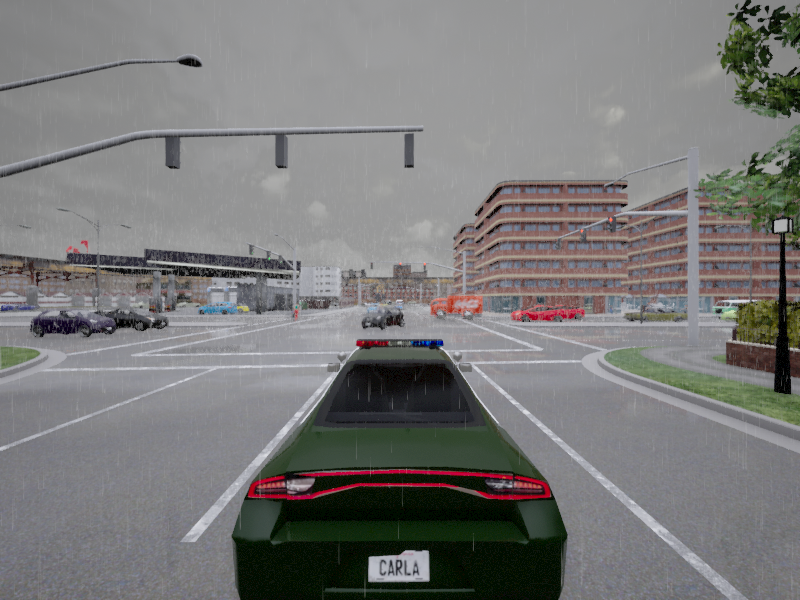

In [82]:


input_file = '/home/oq4116/temp/unet-image-segmentation/data/Images/Video_021/v021_0233.png'
from PIL import Image
from torchvision import transforms

input_image = Image.open(input_file)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((608,800))
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).to('cuda')  # create a mini-batch as expected by the model
print(input_batch.shape)

output = m(input_batch)
print(output.shape)
output_pred = output.argmax(1)
print(output_pred.shape)
display(input_image)

In [16]:
print(input_batch[0][0][0][0:9])
print(output.shape)
print(output_pred[0][0:9])

tensor([0.0569, 0.0569, 0.0741, 0.0569, 0.0569, 0.0741, 0.0569, 0.0741, 0.0741],
       device='cuda:0')
torch.Size([13, 608, 800])
tensor([12, 12, 12, 12, 12, 12, 12, 12, 12], device='cuda:0')


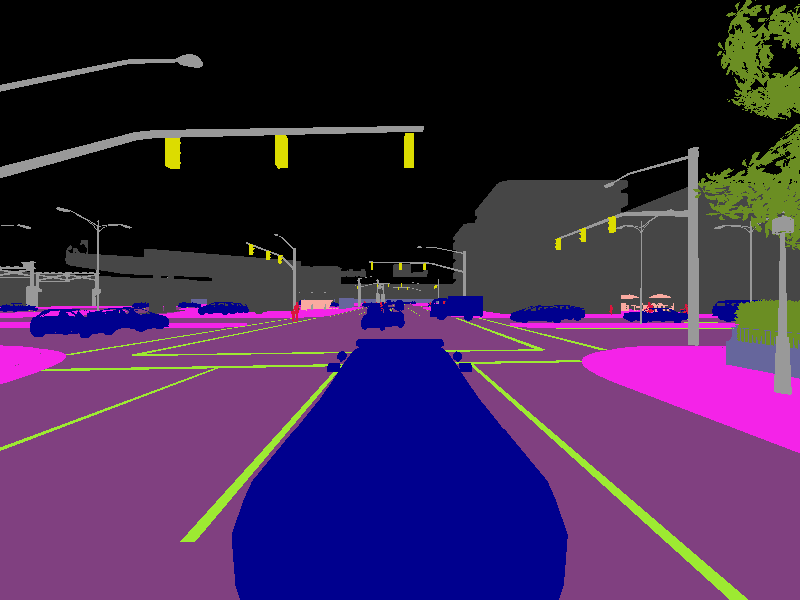

AttributeError: shape

In [27]:
target = '/tools/datasets/DAVID/Labels/Video_021/v021_0233.png'
target_image = Image.open(target)

display(target_image)

VOC_COLORMAP = [
    [0, 220, 220], [70, 70, 70], [153, 153, 190], [160, 170, 250],
    [60, 20, 220], [153, 153, 153], [50, 234, 157], [128, 64, 128],
    [232, 35, 244], [35, 142, 107], [142, 0, 0], [156, 102, 102], [0, 0, 0]
]





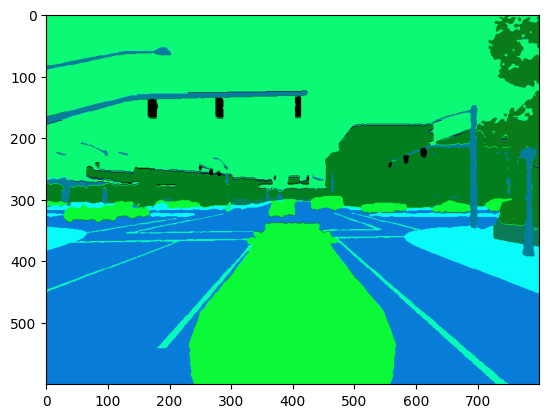

In [7]:

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(13)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_pred.byte().cpu().numpy()).resize(input_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r)

In [ ]:
VOC_COLORMAP = [
    [0, 220, 220], [70, 70, 70], [153, 153, 190], [160, 170, 250],
    [60, 20, 220], [153, 153, 153], [50, 234, 157], [128, 64, 128],
    [232, 35, 244], [35, 142, 107], [142, 0, 0], [156, 102, 102], [0, 0, 0]
]

VOC_CLASSES = np.array([
    'Traffic Sign', 'Building', 'Fence', 'Other', 'Pedestrian', 'Pole', 'Road Line',
    'Road', 'Sidewalk', 'Vegetation', 'Car', 'Wall', 'Unlabeled'
])



In [100]:
e = torch.empty(0)
t = torch.tensor(2)

a = torch.stack([t, t])

float(a.float().mean())

2.0

In [49]:
import matplotlib.image as mpimg

target = '/home/hotfilter/temp/unet-image-segmentation/data/Labels_int/Video_021/v021_0233.png'
data = mpimg.imread(target)*255

data = torch.tensor(data)
data2 = output_pred[4:-4,:].to('cpu')
print(data2.shape)
print(data.shape)
# display(Image.open(target))
res = (data == data2).float().mean()
print(res.shape)
print(res)

torch.Size([600, 800])
torch.Size([600, 800])
torch.Size([])
tensor(0.9567)


In [71]:
from torchvision.datasets import ImageFolder
import torch.utils.data as data
import glob
import os
from PIL import Image


class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, transforms, data_folder="Images", labels_folder="Labels"):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path, data_folder,'*.png'))
        self.mask_files = []
        self.transforms = transforms
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path,labels_folder,os.path.basename(img_path)))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]

            data_img = Image.open(img_path).convert("RGB")
            data = self.transforms(data_img)

            label = mpimg.imread(mask_path) * 255
            return data, torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((608,800))
])
dls = DataLoaderSegmentation('/tools/datasets/DAVID/', preprocess, 'images_raw', 'labels_int')

print(len(dls))



10310


In [80]:
from torch.utils.data import DataLoader

dl = DataLoader(dls, 16)

next(iter(dl))[0].__len__()

16